In [1]:
#Creating a graph to figuratively show the distributed network
class Graph:
    def __init__(self):
        self.graph = {}
        self.power_array = []
        self.thres_SINR = []
        self.awgn = []
        self.distance_BS = []
    
    def add_connections(self, data_array):
        if data_array[0] in self.graph:
            self.graph[data_array[0]].append(data_array[1:])
        else:
            self.graph[data_array[0]] = [data_array[1:]]
    
    def print_connections(self):
        print(self.graph)
        
        #gii and gij 
        #gii average internal channel gain
        #gij average data communication channel gain

### Array Contents
* Parent Node 
* Child Node 
* Channel gain for the parent node
* Average power gain in data transmission

In [2]:
graph = Graph()
graph.power_array = [0.1, 0.25, 0.15, 0.2, 1] #the initial power ratings of the nodes in the graph
parray = graph.power_array
orgparray = [0.1, 0.25, 0.15, 0.2, 1]
graph.thres_SINR = [5, 6, 4, 5, 6] #assigning threshold SINR values to each power source
graph.awgn = [0.03, 0.04, 0.05, 0.06, 0.05] #assigning the σ(sigma) also known as additive white gaussian noise value for each node
graph.distanceBS = [1.5, 2, 3, 4, 5]

#giving each node of the network the other nodes to which each nodes are connected 
#along with the average internal channel gain(gii) and the external channel gain between the two nodes in communication(gij)
graph.add_connections([0, 2, 0, 0, 1])
graph.add_connections([0, 3, 0, 0, 2])
graph.add_connections([1, 0, 0, 0, 3])
graph.add_connections([2, 1, 0, 0, 4])
graph.add_connections([2, 3, 0, 0, 5])
graph.add_connections([3, 4, 0, 0, 6])
graph.add_connections([4, 0, 0, 0, 7])


In [3]:
graph.graph

{0: [[2, 0, 0, 1], [3, 0, 0, 2]],
 1: [[0, 0, 0, 3]],
 2: [[1, 0, 0, 4], [3, 0, 0, 5]],
 3: [[4, 0, 0, 6]],
 4: [[0, 0, 0, 7]]}

In [4]:
def cal_expected_value(zero_gaussian, hii):
    n = len(zero_gaussian)
    sums = 0
    for i in range(n):
        exponent = 0.1*zero_gaussian[i]
        sums += hii*(10**(exponent))
    return sums/n

In [5]:
import numpy as np
import math
zero_gaussian = np.random.normal(0,1,1000)
gii_array = [0]*len(parray)
def gii_function():
    global parray
    hii_ = 0.97
    pl_exponent = -2 #free space
    scale_parameter = 2
    for node in graph.graph:
        hii = hii_*(graph.distanceBS[node]**(-2))
        gii = cal_expected_value(zero_gaussian, hii)
        gii_array[node] = gii

gii_function()
gii_array

[0.44272711999039294,
 0.24903400499459594,
 0.11068177999759823,
 0.062258501248648984,
 0.03984544079913543]

In [6]:
def gij_function():
    global parray
    hii_ = 0.97
    pl_exponent = 2 #free space
    scale_parameter = 2
    for node in graph.graph:
        for i in range(len(graph.graph[node])):
            #import pdb; pdb.set_trace()
            hii = hii_*(graph.graph[node][i][3]**(-pl_exponent))
            gij = cal_expected_value(zero_gaussian, hii)
            graph.graph[node][i][2] = gij

gij_function()
graph.graph

{0: [[2, 0, 0.9961360199783837, 1], [3, 0, 0.24903400499459594, 2]],
 1: [[0, 0, 0.11068177999759823, 3]],
 2: [[1, 0, 0.062258501248648984, 4], [3, 0, 0.03984544079913543, 5]],
 3: [[4, 0, 0.02767044499939956, 6]],
 4: [[0, 0, 0.02032930653017112, 7]]}

In [7]:
def summation_Gij(node, array):
    sums = 0
    for i in range(len(graph.graph[node])):
            sums += ((graph.graph[node][i][2]/gii_array[node])*array[graph.graph[node][i][0]])
    return sums

In [8]:
omega =[0]*len(parray)
def omega_function(array):
    for node in graph.graph:    
        #finding the value of summation of Gij
        sums = summation_Gij(node, array)
        #import pdb; pdb.set_trace()
        deno = (graph.thres_SINR[node]*(sums + graph.awgn[node]/gii_array[node]))
        value = (1+(array[node]/deno))
        omega[node] = value

In [9]:
#Step 3 of the algorithm
#calulating the value for the variable that helps in providing the parametric form of the optimization problem (u)
u_array = [0]*len(parray)
def u_function(array):
    for node in graph.graph:
        #finding the value of summation of Gij
        sums = summation_Gij(node, array)
        deno = (graph.thres_SINR[node]*(sums + graph.awgn[node]/gii_array[node]))
        u_demo = (array[node] + deno)**4
        u_value = (array[node]*omega[node])**2/u_demo
        u_array[node] = u_value

In [10]:
#Step 4 of the algorithm
#finding the optimal power allocation in a distributed system for max throughput
power_array = []
import math
def new_power_function():
    global parray
    for node in graph.graph:
        sums = 0
        #finding the value of summation of Gij
        for i in range(len(graph.graph[node])):
            sums += (graph.graph[node][i][2]/gii_array[node])
        deno = u_array[node]*(1+(graph.thres_SINR[node]*sums))**2
        new_power = omega[node]**2/deno
        #Step 5 of the algorithm
        #If the difference between the new power and the old power obtained is greated than convergence threshold
        #then the old power = new power
        #here, convergence threshold = 20
        if math.ceil(abs(new_power - parray[node]))>0.75:
            parray[node] = new_power

In [11]:
#finding the maximum power allocation for ten iterations of data communications
for i in range(3):
    omega_function(parray)
    u_function(parray)
    new_power_function()

In [12]:
#Final power ratings of each of the nodes in the network 
#for providing maximum throughput rates in a distributed power allocation system
graph.power_array

[1.7113496415074817e+22,
 5.085519122338345e+39,
 2.9013087156177445e+19,
 4496364971227.97,
 5.448128100850093e+40]

[0.1, 0.25, 0.15, 0.2, 1]
[1.7113496415074817e+22, 5.085519122338345e+39, 2.9013087156177445e+19, 4496364971227.97, 5.448128100850093e+40]


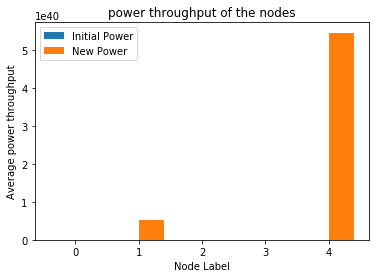

In [20]:
import matplotlib.pyplot as plt
import numpy as np


average_power_values = orgparray
print(orgparray)
nodes = [0, 1, 2, 3, 4]

power_ratings = []
nodes = [0, 1, 2, 3, 4]
for i in parray:
    power_ratings.append(round(i,2))
print(power_ratings)

x_axis = np.arange(len(nodes))
plt.bar(x_axis - 0.2,average_power_values, 0.4, label='Initial Power')
plt.bar(x_axis + 0.2,power_ratings, 0.4, label='New Power')

plt.xticks(x_axis, nodes)
plt.ylabel("Average power throughput")
plt.xlabel("Node Label")
plt.title("power throughput of the nodes")
plt.legend()
plt.show()


In [14]:
import math
from math import log
newparray = [0.1, 0.25, 0.15, 0.2, 1]
piap = [0.2, 0.4, 0.6, 0.8, 0.3]
picp = [0.3, 0.6, 0.9, 0.08, 0.1]
e = 0.02
Oth = 0.5

In [15]:
v_array = [0]*len(newparray)
def v_function():
    global newparray
    for node in graph.graph:
        numerator = log(omega[node])**2
        denominator = (e*newparray[node] + piap[node] + picp[node])**4
        v_array[node] = numerator/denominator

In [16]:
alpha_array = [0]*len(newparray)
def alpha_function():
    global newparray
    for node in graph.graph:
        alpha_array[node] = 1/omega[node]

In [17]:
def newnew_power_function():
    global newparray
    for node in graph.graph:
        #finding the value of summation of Gij
        sums = summation_Gij(node, newparray)
        #minimum transmit power required to get target SINR
        #import pdb; pdb.set_trace();
        val1 = -1*(sums + graph.awgn[node]/gii_array[node])*(graph.thres_SINR[node]/(log(1-Oth)))
        #user transmit power
        num1 = 4*alpha_array[node]*u_array[node]*v_array[node]*omega[node]
        last = (1+graph.thres_SINR[node]*sums)
        deno1 = (v_array[node] + (2*u_array[node]*(math.sqrt(v_array[node]))*last))**2
        val2 = num1/deno1
        new_power = max(val1, val2)
        if math.ceil(abs(new_power - newparray[node]))>0.25:
            newparray[node] = new_power

In [18]:
for i in range(3):
    omega_function(newparray)
    u_function(newparray)
    v_function()
    alpha_function()
    newnew_power_function()

In [19]:
newparray

[187522.23768817206,
 721434.4633439005,
 2342021.5822155867,
 13082.485460476864,
 828186.583722213]